# IMDB Data EDA

## Data

Two datasets:
- tmdb_5000_movies.csv
- movie_metadata.csv


## Goal

What makes a profitable movie?


## Index

1- Loading and merging datasets

2- What makes gross revenue increase? How are these variables related to each other?

3- What actors and directors have the highest budget to gross ratio?

4- What movies where the biggest flops? Are there factors that are associated with flops?

5- What countries make the most profitable and valued films?


### 1- Loading, cleaning and merging datasets

We'll need to load the datasets, analyze their content and quality, clean de unnecessary columns, create categorical features where needed and finally merge everything into a common and usable Pandas Dataframe. 

In [161]:
# Import the needed libraries for the EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

warnings.filterwarnings('ignore')
%matplotlib inline

In [162]:
#Import the three downloaded datasets into DFs and review the first 10 entries

df_movies = pd.read_csv('Datasets/tmdb_5000_movies.csv')
df_metadata = pd.read_csv('Datasets/movie_metadata.csv')

print("Movies DF:\n\n{}\n".format(df_movies.head()))
print("Metadata DF:\n\n{}".format(df_metadata.head()))

Movies DF:

      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id

Let's see what kind of data are we working with

In [163]:
print("Movies DF:\n")
print(df_movies.info(),"\n\n")
print(df_movies.describe(),"\n\n")
print(df_movies['original_language'].value_counts())
print("\n{}".format(df_movies['status'].value_counts()))
print("\n\nNulls:\n\n{}\n\n**************************************\n\n".format(df_movies.isnull().sum()))

print("Metadata DF:\n")
print(df_metadata.info(),"\n\n")
print(df_metadata.describe(),"\n\n")
print(df_metadata['color'].value_counts())
print("\n{}".format(df_metadata['content_rating'].value_counts()))
print("\n{}".format(df_metadata['aspect_ratio'].value_counts()))
print("\n\nNulls:\n\n{}\n\n**************************************\n\n".format(df_metadata.isnull().sum()))

Movies DF:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              48

We can see from the list of columns that some of them are repeated, let's get rid of them

In [164]:
df_metadata.drop(['num_critic_for_reviews','duration','gross','genres',
                 'num_voted_users','plot_keywords','num_user_for_reviews',
                 'budget','title_year','imdb_score'],axis=1,inplace=True)

#We can also get rid of the text description of the films, as it won't be necessary for our study
df_movies.drop('overview',axis=1,inplace=True)

#And we can drop the production country and language columns and keep the country and language from metadata
df_movies.drop(['production_countries','spoken_languages'],axis=1,inplace=True)

We should change categorical data and dictionaries into columns for easier manipulation and visualization

In [165]:
#First let's extract the important info out the string columns that contain of lists of dictionaries

patternname = r"(?:.name.: .)(\w{1,}\s{0,}\w{0,})"
patternlang = r"(?:.iso_639_1.: .)(\w{1,}\s{0,}\w{0,})"

def dict2list(x):
    if type(x) is str:
        templist = x.strip('[]').split(',')
        namelist = []
        lang = False
        for element in templist:
            if re.search(patternlang, element):
                namelist.append(re.search(patternlang, element).group(0)[14:])
                lang = True
            elif re.search(patternname, element) and not lang:
                namelist.append(re.search(patternname, element).group(0)[9:])
        if len(namelist) > 0:
            return {k: 1 for k in namelist}
        else:
            return x
    else:
        return x

df_movies = df_movies.applymap(dict2list)

In [166]:
#Second, lets use the newly created dictionaries to create dummy columns for the categorical columns

def dicttodummy(df,columns):
    columnnames = {}
    for col in columns:
        columnnames[col] = list(df[col].apply(pd.Series).drop([0], axis=1))
        df = pd.concat([df.drop([col], axis=1), df[col].apply(pd.Series).fillna(0).drop([0], axis=1)], axis=1)
    return df,columnnames

dummyfeatures = ['genres']
df_movies,columndictionary = dicttodummy(df_movies,dummyfeatures)

In [167]:
#Now we can merge both the dataframes into one

df_metadata['movie_title'] = df_metadata['movie_title'].map(lambda x: x.strip())
data = pd.merge(df_movies, df_metadata, left_on='original_title'
                , right_on='movie_title', how='left').drop(['movie_title'], axis=1)

print(data.head())

      budget                                      homepage      id  \
0  237000000                   http://www.avatarmovie.com/   19995   
1  300000000  http://disney.go.com/disneypictures/pirates/     285   
2  245000000   http://www.sonypictures.com/movies/spectre/  206647   
3  250000000            http://www.thedarkknightrises.com/   49026   
4  260000000          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  {'culture clash': 1, 'future': 1, 'space war':...                en   
1  {'ocean': 1, 'drug abuse': 1, 'exotic island':...                en   
2  {'spy': 1, 'based on': 1, 'secret agent': 1, '...                en   
3  {'dc comics': 1, 'crime fighter': 1, 'terroris...                en   
4  {'based on': 1, 'mars': 1, 'medallion': 1, 'sp...                en   

                             original_title  popularity  \
0                                    Avatar  150.437577   
1  Pirates of th

### 2- What makes gross revenue increase? How are these variables related to each other?

We need to evaluate genre, content rating (R, PG13, etc.), budget, movie FB likes, IMDB likes, etc. We should also evaluate how the important of those features changed with time.

#### - First of all, we should understand how is the revenue variable. An histogram should be useful.

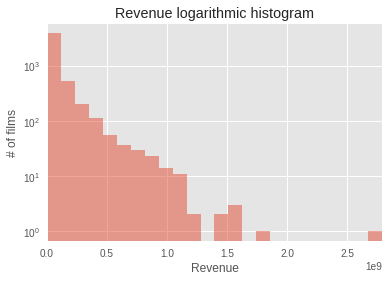

In [168]:
def plotHistogram(df,col,tit='',xlabel='',ylabel='',log=False):
    bins = np.linspace(df[col].min(),df[col].max(),25)
    plt.xlim([df[col].min(),df[col].max()])
    plt.hist(df[col], bins=bins, alpha=0.5,log=log)
    plt.title(tit)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plotHistogram(data,'revenue',ylabel='# of films',xlabel='Revenue',tit='Revenue logarithmic histogram',log=True)

The log plot tells us that the distribution is close to an exponential

#### - Let's see how revenue correlates with some other film figures

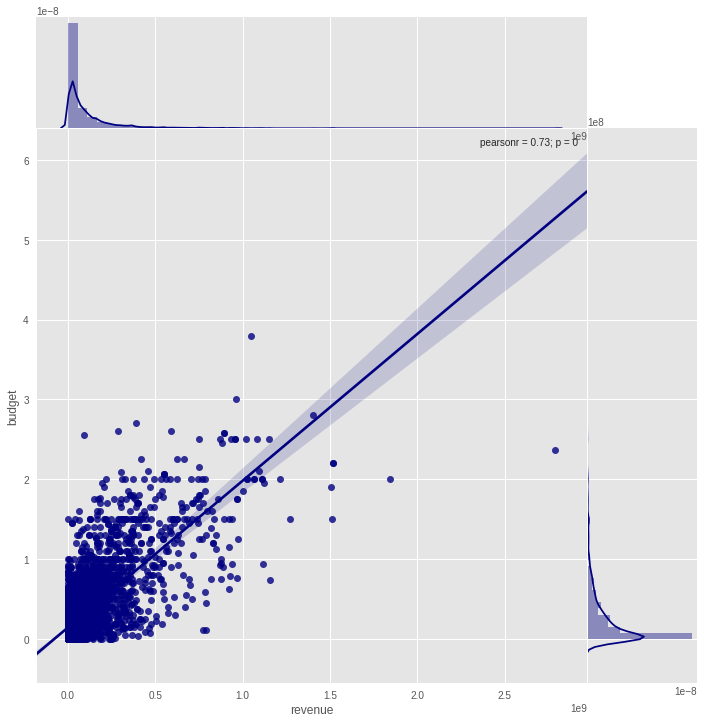

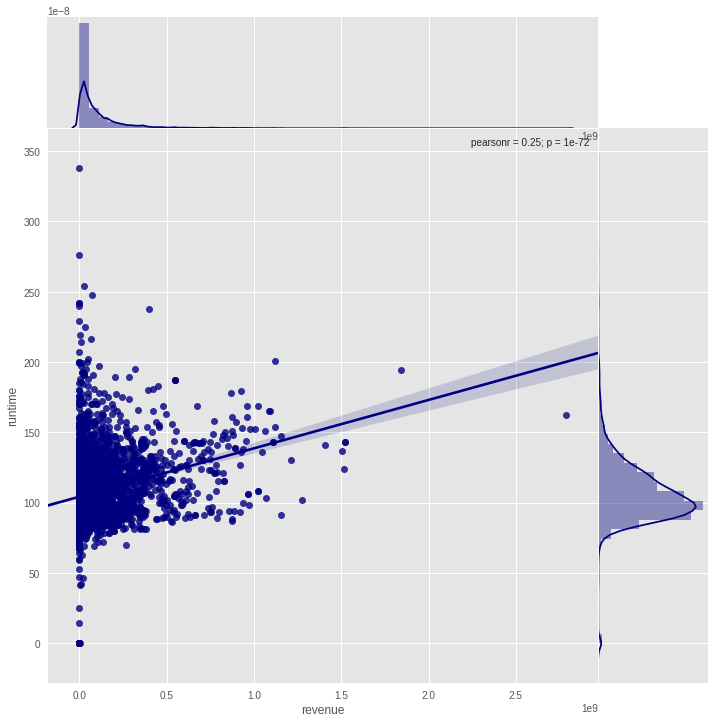

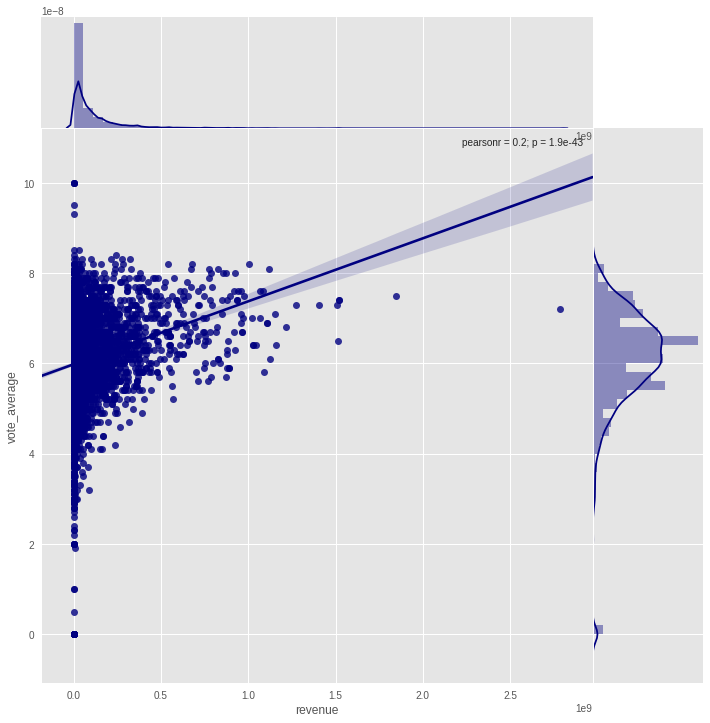

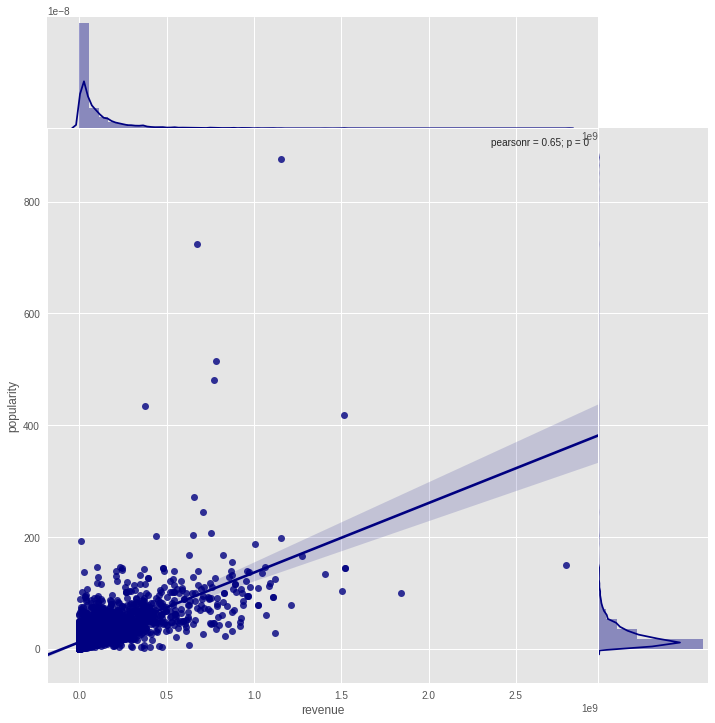

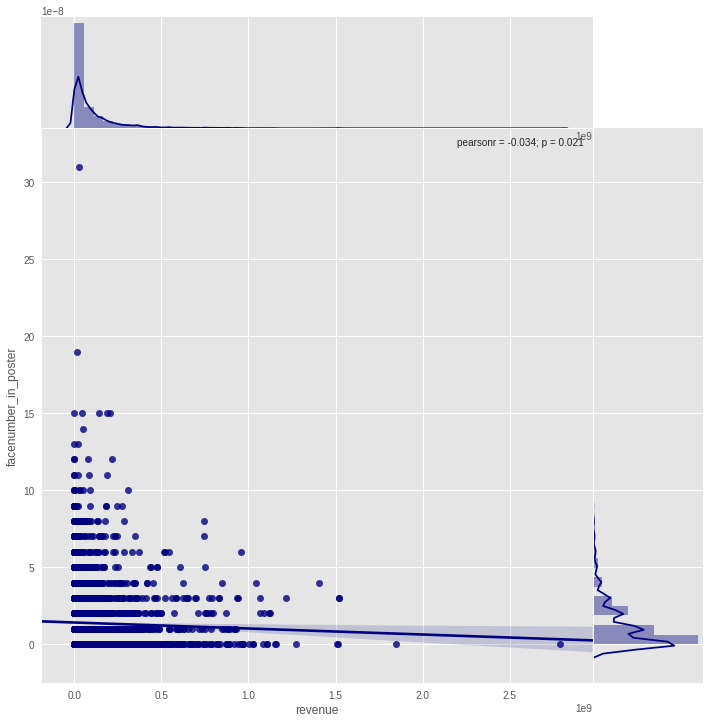

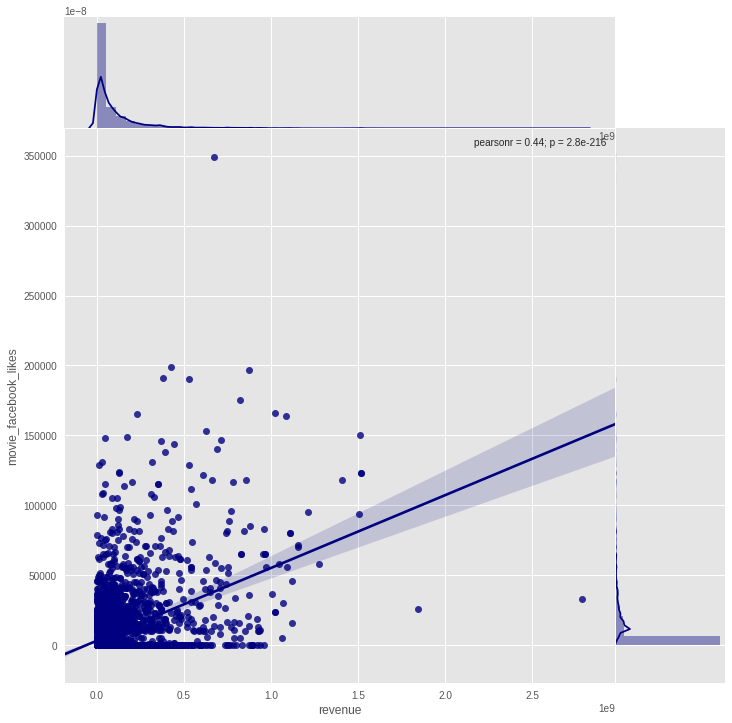

In [169]:
#Array with the column names for what we want to compare the revenue to
revenue_comparisons = ['budget', 'runtime', 'vote_average', 'popularity','facenumber_in_poster','movie_facebook_likes']

#Iterate through each of the columns made above and plots them separately
for comparison in revenue_comparisons:
    sns.jointplot(x='revenue', y=comparison, data=data, color='navy', size=10, space=0, kind='reg')

We can see how the strongest relationship to revenue is budget (0.73) and the weakest, obviously, the number of faces in the promotional poster, with a p that would not allow to reject the null hypothesis if we set a confidence over 99%. The correlation of popularity and FB movie likes is also evident, but surprisingly there's also a positive correlation between runtime and revenue (0.25), so this would lead us to advise, if anything, against a short film.

#### - Let's see now the correlation between all these variables among themselves.

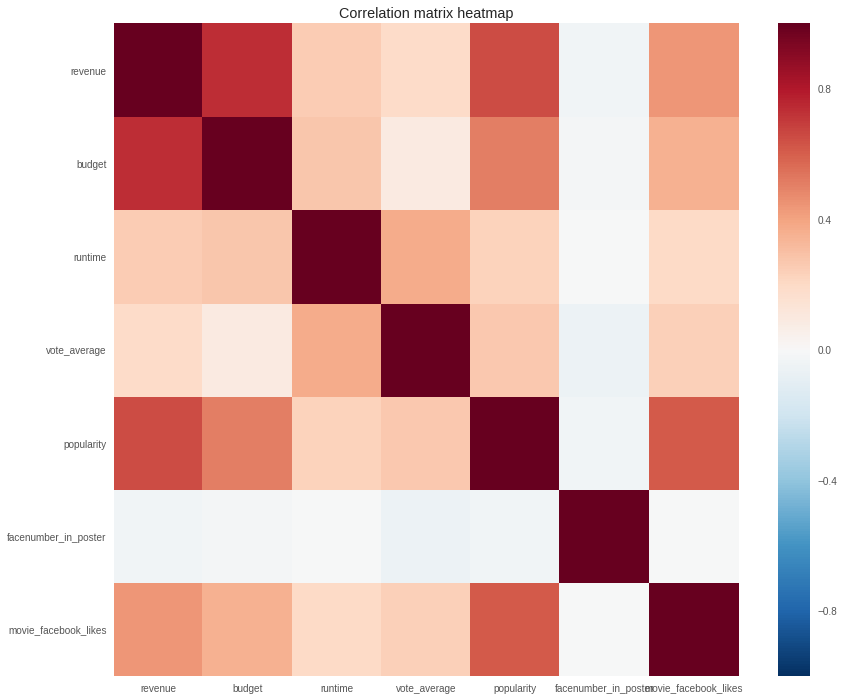

In [170]:
fig, ax = plt.subplots(figsize=(14,12));
new = data[['revenue','budget', 'runtime', 'vote_average', 'popularity','facenumber_in_poster','movie_facebook_likes']].copy()
new = new.corr()
sns.heatmap(new, ax=ax);
ax.set_title('Correlation matrix heatmap');

#### - Is the type of film content rating important for its profitability?

To know that, ee need to create a new column, revenue_budget_ratio.

                revenue_budget_ratio
content_rating                      
G                           5.826984
Not Rated                   4.179610
PG                          4.892081
PG-13                       3.058953
R                           4.657879


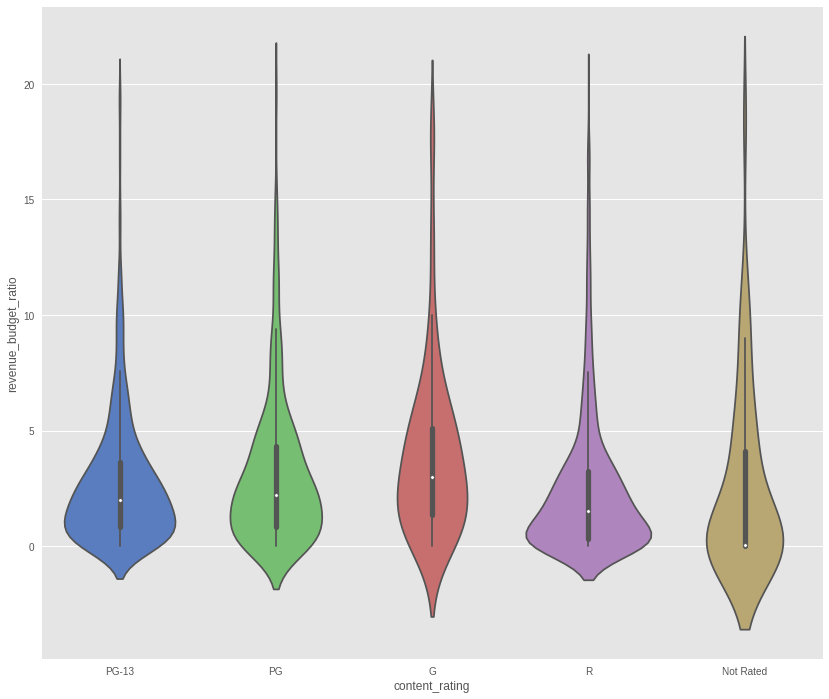

In [171]:
##We'll filter by a budget of $100k to avoid independent films
minbudget = 100000
data['revenue_budget_ratio'] = data['revenue'][data['budget']>minbudget]/data['budget'][data['budget']>minbudget]

#We will filter to show only ratings with more than 100 films in the DB
ratinglist = df_metadata.content_rating.value_counts()[df_metadata.content_rating.value_counts() >= 100]

fig, ax = plt.subplots(figsize=(14,12));
ax = sns.violinplot(x='content_rating', y="revenue_budget_ratio"
                    ,data=data[data.content_rating.isin(ratinglist.index.values[:])][data.revenue_budget_ratio<20]
                    , palette="muted", split=True)
ax.set_ylim = (100)

print(data[['revenue_budget_ratio','content_rating']][data.content_rating.isin(ratinglist.index.values[:])]
      .groupby('content_rating').mean())

We can see how the content rating is in fact affecting the ratio distribution shape, being the G rated films the ones with a higher profitability ratio and the PG-13 those who have a lower one.

#### - Is budget a factor in profitability of films? 

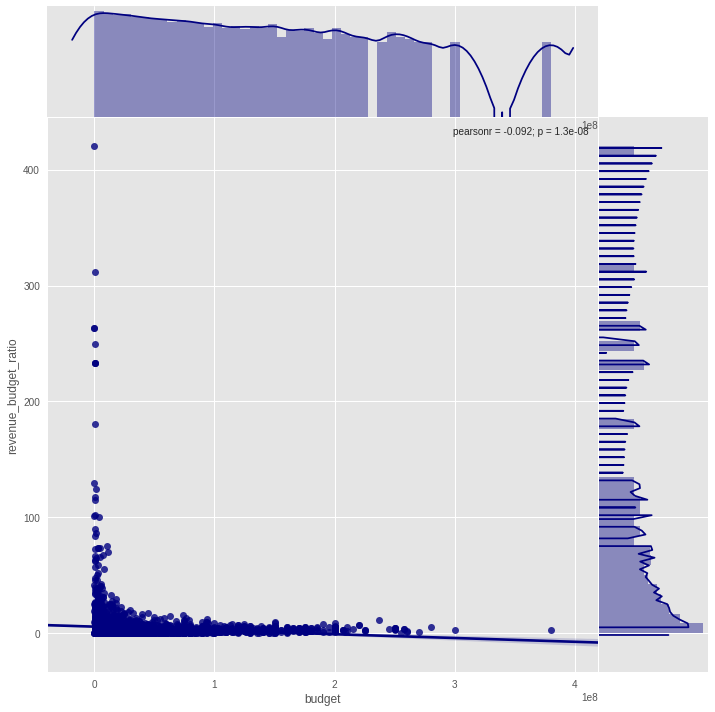

In [172]:
sns.jointplot(x='budget', y='revenue_budget_ratio', data=data, kind='reg', color='navy'
              , size=10, space=0,marginal_kws={'hist_kws': {'log': True}})

We can see how, although budget strongly correlates with revenue, it does negatively affect the films potential for profitabilty.

#### - How does revenue and profitability behaves for the main film genres?

We will filter for the 7 main genres by film count.

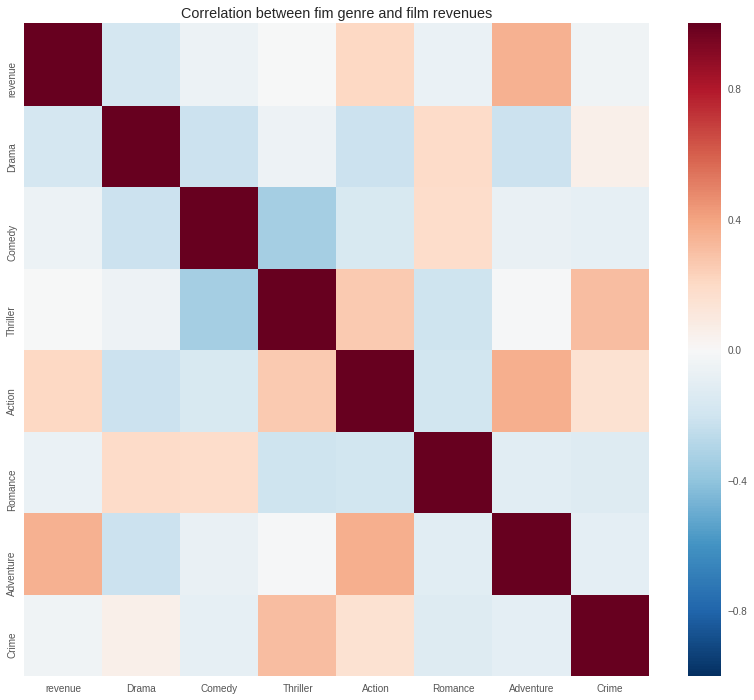

In [202]:
main_genres = df_movies[columndictionary.get('genres')].sum().sort_values(ascending=False).head(7).index.values[:]

fig, ax = plt.subplots(figsize=(14,12));
new = data[['revenue',main_genres[0],main_genres[1],main_genres[2]
            ,main_genres[3],main_genres[4],main_genres[5],main_genres[6]]].copy()
new = new.corr()
sns.heatmap(new, ax=ax);
ax.set_title('Correlation between fim genre and film revenues');

It seems that Thrillers and Action films correlates with a higher revenue. 

#### - But what about film profitability? Does it favor any specific genre?

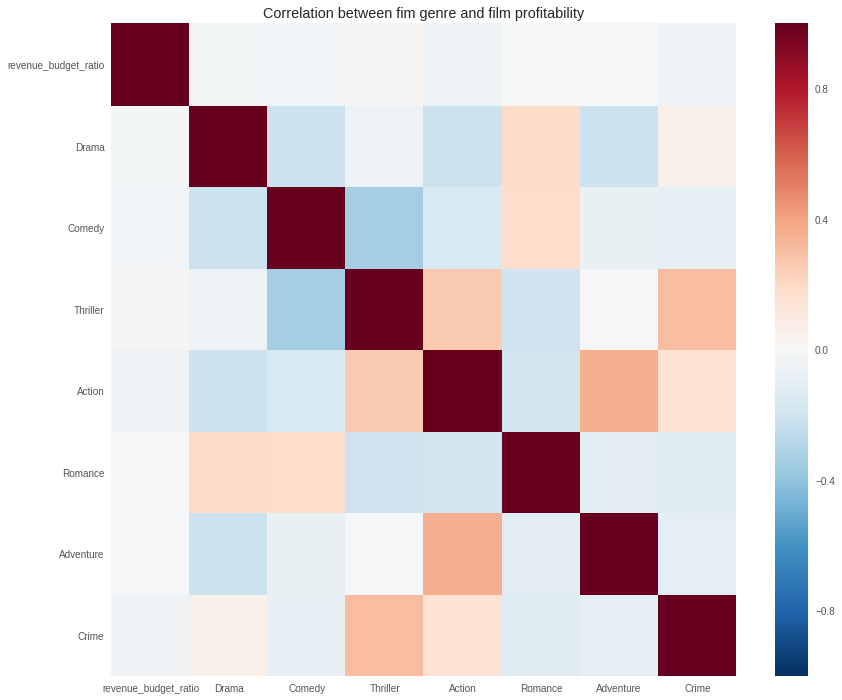

In [203]:
fig, ax = plt.subplots(figsize=(14,12));
new = data[['revenue_budget_ratio',main_genres[0],main_genres[1],main_genres[2]
            ,main_genres[3],main_genres[4],main_genres[5],main_genres[6]]].copy()
new = new.corr()
sns.heatmap(new, ax=ax);
ax.set_title('Correlation between fim genre and film profitability');

It seems that there is no genre in particular that correlates with a higher or lower profitability.

### 3- What actors and directors have the highest revenue to budget ratio?

Which directors and actors have the highest average IMBD rating? Which is more loved in facebook? Which ones get the most profitable films? Do any of these have any correlation?

In [204]:
def showbarplot(df,col,tit='',col2=None,nelements=5,tail=False,ylim=None):
    plt.rcParams["figure.figsize"] = [nelements*2,6]
    fig, ax = plt.subplots()
    width = 0.7
    ind = np.arange(nelements)
    
    if tail:
        bars = df[col].sort_values(ascending=False).tail(nelements)
        plt.xticks((ind), df[col].sort_values(ascending=False).tail(nelements).index.tolist(), rotation=45)
    else:
        bars = df[col].sort_values(ascending=False).head(nelements)
        plt.xticks((ind), df[col].sort_values(ascending=False).head(nelements).index.tolist(), rotation=45)
    
    rects = ax.bar(range(len(bars)), bars, width = width, color='navy')
    ax.set_title(tit)
    
    if col2:
        if tail:
            labels = df[[col,col2]].sort_values(by=col,ascending=False).tail(nelements)[col2]
        else:
            labels = df[[col,col2]].sort_values(by=col,ascending=False).head(nelements)[col2]
        
        plt.legend(['n='+str(col2)], loc=1)
        for i,rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height*1.05,'n='+str(int(labels[i]))
                    , ha='center', va='bottom')
    
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
        
    plt.show()

In [208]:
df_directors = data.groupby('director_name').apply(lambda x: \
                                                   pd.Series({'Director_likes':x.director_facebook_likes.mean(),
                                                            'Movie_likes_mean':x.movie_facebook_likes.mean(),
                                                            'revenue_budget_ratio':x.revenue_budget_ratio.mean(),
                                                            'budget_mean':x.budget.mean(),
                                                            'revenue_mean':x.revenue.mean(),
                                                            'runtime':x.runtime.mean(),
                                                            'vote_average':x.vote_average.mean(),
                                                            'films':x.director_name.count()}))

#### - Let's see the directors with a highest average revenue figures

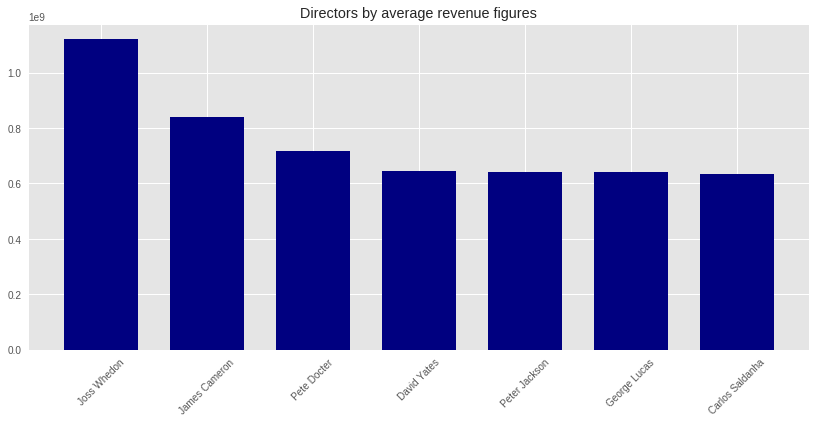

Directors by average revenue figures:

               revenue_mean  films   budget_mean  vote_average
director_name                                                 
Joss Whedon    1.120847e+09    4.0  1.897500e+08      7.375000
James Cameron  8.405099e+08    7.0  1.067000e+08      7.328571
Pete Docter    7.185088e+08    3.0  1.550000e+08      7.733333
David Yates    6.464145e+08    4.0  1.900000e+08      6.450000
Peter Jackson  6.410140e+08   12.0  1.476667e+08      7.150000


In [209]:
#As we will be considering mean revenues, we'll filter by directors with at least 3 films in the DB

showbarplot(df_directors[df_directors.films>2],'revenue_mean'\
            ,tit='Directors by average revenue figures',nelements=7)

print("Directors by average revenue figures:\n")
print(df_directors[['revenue_mean','films','budget_mean','vote_average']][df_directors.films>2]\
      .sort_values(by="revenue_mean",ascending=False).head())

But that didn't show the profitability of the directors...

#### - Let's see now the directors with at least 3 films with the highest profitable ratios

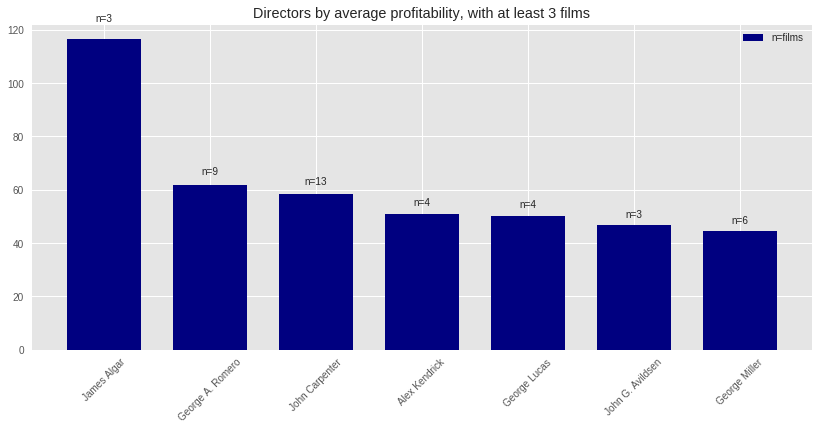



Directors by average profitability, with at least 3 films:

                  films  revenue_budget_ratio   budget_mean  vote_average
director_name                                                            
James Algar         3.0            116.463252  2.771267e+07      7.000000
George A. Romero    9.0             61.866891  4.914222e+06      6.466667
John Carpenter     13.0             58.295124  1.468462e+07      6.600000
Alex Kendrick       4.0             50.717427  4.000000e+05      6.800000
George Lucas        4.0             50.287875  8.719425e+07      6.675000


In [210]:
showbarplot(df_directors[df_directors.films>2],'revenue_budget_ratio',col2='films'\
            ,tit='Directors by average profitability, with at least 3 films',nelements=7)

print("\n\nDirectors by average profitability, with at least 3 films:\n")
print(df_directors[['films','revenue_budget_ratio','budget_mean','vote_average']]\
      [df_directors.films>2].sort_values(by="revenue_budget_ratio",ascending=False).head())

We can see how George Romero, John Carpenter  and GeorgeMiller have the biggest revenue to budget ratio, having all of them more than 5 films in their IMDB database profiles.

#### - Let's see now other stats about directors, like FB fans

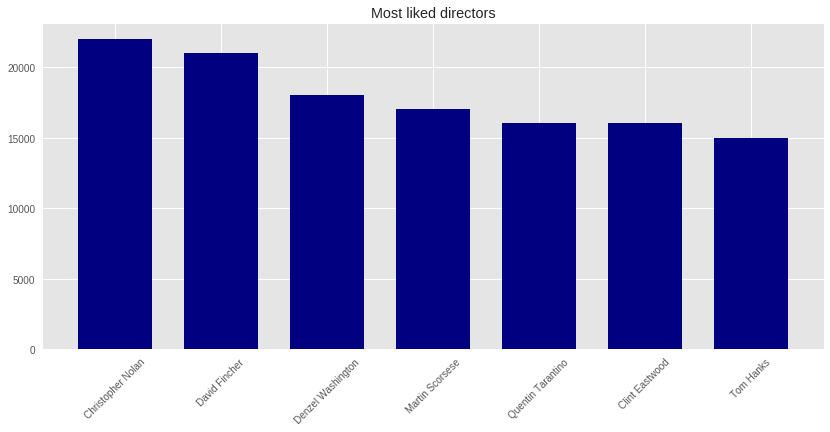

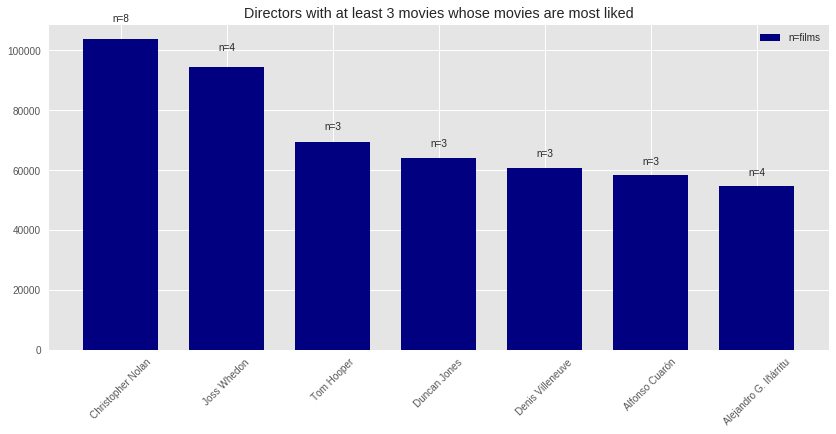

In [211]:
showbarplot(df_directors[df_directors.revenue_budget_ratio>0],'Director_likes'\
            ,tit='Most liked directors',nelements=7)

#We'll filter directors with less than 3 films in the df for the movie means average

showbarplot(df_directors[df_directors.films>2],'Movie_likes_mean',col2='films'\
            ,tit='Directors with at least 3 movies whose movies are most liked',nelements=7)

It seems Christopher Nolan has a touch with the audience!

#### - But does having more FB likes relates to a higher profitability for directors?

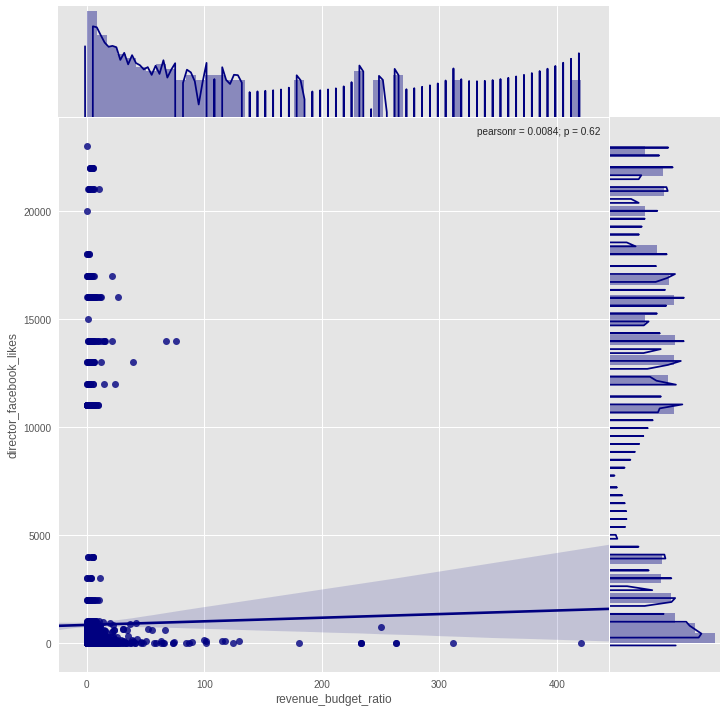

In [212]:
sns.jointplot(x='revenue_budget_ratio', y='director_facebook_likes', data=data, color='navy', kind='reg'
              , size=10, space=0,marginal_kws={'hist_kws': {'log': True}})

The number of FB likes of the director and film profitability (revenue/budget ratio) doesn't seem to be important. 

#### - What if we chose to compare against the revenue of their films?

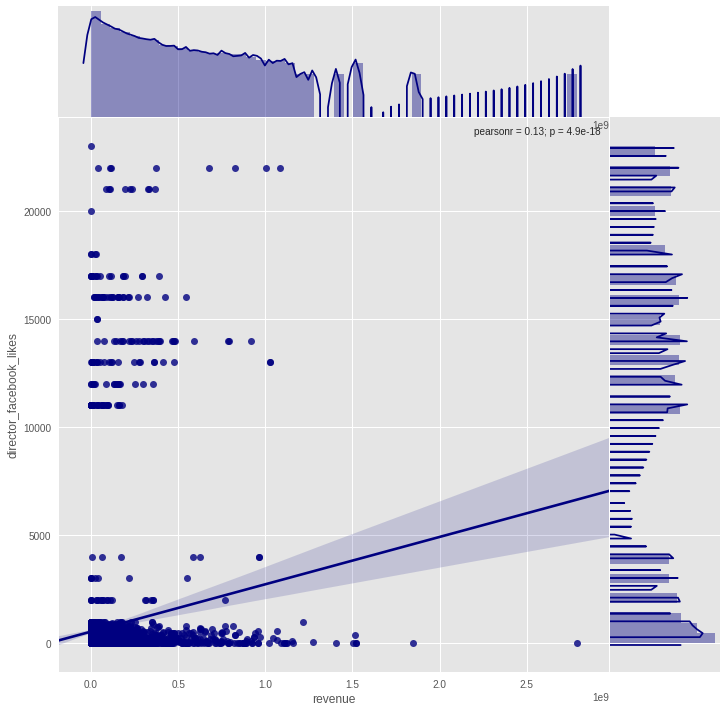

In [213]:
sns.jointplot(x='revenue', y='director_facebook_likes', data=data, color='navy', kind='reg'
              , size=10, space=0,marginal_kws={'hist_kws': {'log': True}})

We can see how the directors of films with great revenues tend to have more FB likes, although that doesn't seem to imply that the profitability of their films are higher.

#### - Can we relate the FB likes of the cast to the profitability of the film? What about its revenue?

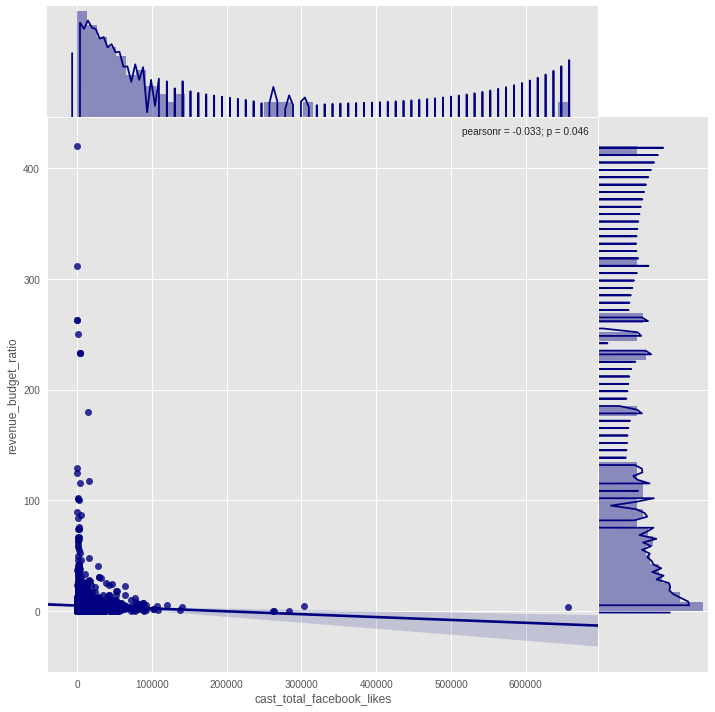

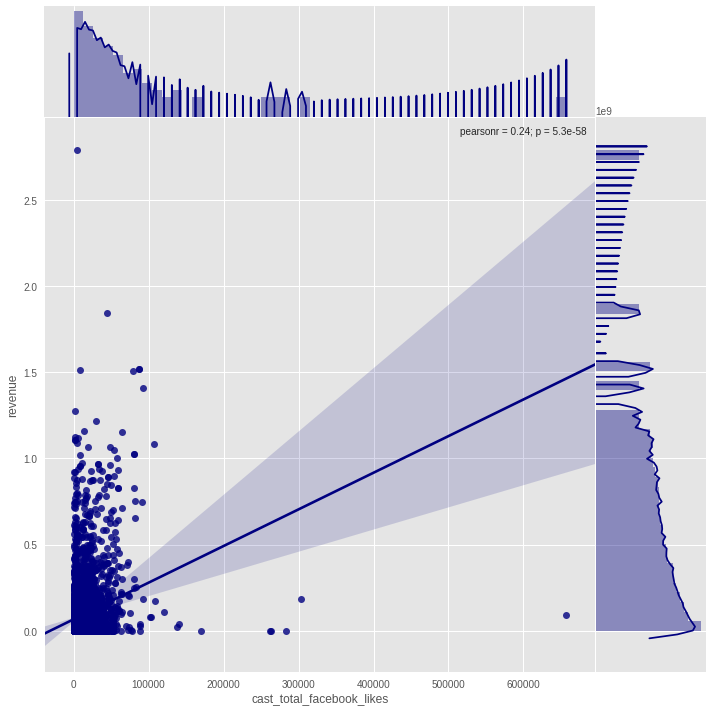

In [214]:
sns.jointplot(x='cast_total_facebook_likes', y='revenue_budget_ratio', data=data
              , kind='reg', color='navy', size=10, space=0,marginal_kws={'hist_kws': {'log': True}})

sns.jointplot(x='cast_total_facebook_likes', y='revenue', data=data
              , kind='reg', color='navy', size=10, space=0,marginal_kws={'hist_kws': {'log': True}})

As it happened with the directors, the FB likes of the main cast doesn't positively correlate with the profitability of the film, but it clearly does with its revenue. In this case, the profitability of the film is negatively correlated with the number of FB likes of the cast, with a p of 0.046, so its negative correlation would be accepted with a confidence of 95%, and the positive correlation of FB likes and total film revenue is also clearer in this case, with a r of 0.24.

Let's create a specific dataframe for the 3 main actors in each film, to evaluate them separately.

In [215]:
actor1 = data[['actor_1_name','actor_1_facebook_likes','revenue','revenue_budget_ratio','vote_average']]\
    .rename(index=str, columns={"actor_1_name": "actor", "actor_1_facebook_likes": "actor_FB_likes"})
actor2 = data[['actor_2_name','actor_2_facebook_likes','revenue','revenue_budget_ratio','vote_average']]\
    .rename(index=str, columns={"actor_2_name": "actor", "actor_2_facebook_likes": "actor_FB_likes"})
actor3 = data[['actor_3_name','actor_3_facebook_likes','revenue','revenue_budget_ratio','vote_average']]\
    .rename(index=str, columns={"actor_3_name": "actor", "actor_3_facebook_likes": "actor_FB_likes"})

actors = pd.concat([actor1, actor2, actor3]).reset_index(drop=True)

df_actors = actors.groupby('actor').apply(lambda x: pd.Series({'Actor_likes':x.actor_FB_likes.mean(),
                                                               'revenue_budget_ratio':x.revenue_budget_ratio.mean(),
                                                               'revenue_mean':x.revenue.mean(),
                                                               'vote_average':x.vote_average.mean(),
                                                               'films':x.actor.count()}))

#### - Which are the actors with higher revenue figures and which are the most profitable for their movies?

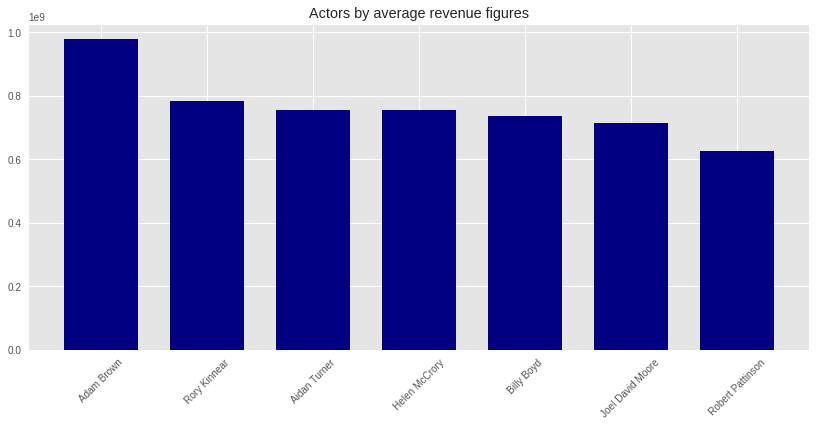

Actors by average revenue figures:

               revenue_mean  films  vote_average
actor                                           
Adam Brown     9.785078e+08    3.0      7.233333
Rory Kinnear   7.834886e+08    5.0      6.840000
Aidan Turner   7.565222e+08    4.0      6.975000
Helen McCrory  7.545310e+08    3.0      7.100000
Billy Boyd     7.353436e+08    4.0      7.250000


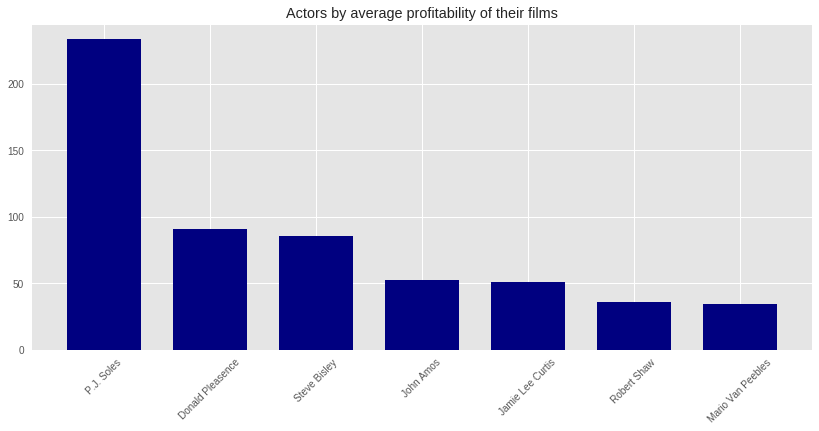

Actors by average profitability of their films:

                  revenue_budget_ratio  films  vote_average
actor                                                      
P.J. Soles                  233.333333    4.0      6.625000
Donald Pleasence             91.204135    8.0      6.787500
Steve Bisley                 85.562161    3.0      7.066667
John Amos                    52.381174    4.0      5.775000
Jamie Lee Curtis             50.970037   15.0      6.106667


In [216]:
showbarplot(df_actors[df_actors.films>2],'revenue_mean',tit='Actors by average revenue figures',nelements=7)

print("Actors by average revenue figures:\n")
print(df_actors[['revenue_mean','films','vote_average']][df_actors.films>2]\
      .sort_values(by="revenue_mean",ascending=False).head())


showbarplot(df_actors[df_actors.films>2],'revenue_budget_ratio'
            ,tit='Actors by average profitability of their films',nelements=7)

print("Actors by average profitability of their films:\n")
print(df_actors[['revenue_budget_ratio','films','vote_average']][df_actors.films>2]\
      .sort_values(by="revenue_budget_ratio",ascending=False).head())

### 4- What movies where the biggest flops? Are there factors that are associated with flops?

What are the number of films that have grossed less than their budgets by year? Is that changing through time?

#### - It would be interesting to visit first the evolution of films profitability throughout the years

In [218]:
data['release_date'] = pd.to_datetime(data['release_date'])

df_years = data.groupby(data.release_date.dt.year).apply\
(lambda x: pd.Series({'revenue_ratio_median':x.revenue_budget_ratio.median(),
                    'ratio_top25':x.revenue_budget_ratio.quantile(.75),
                    'ratio_bottom25':x.revenue_budget_ratio.quantile(.25),
                    'flops_ratio':(x[x.revenue_budget_ratio<1].release_date.count())/x.release_date.count(),
                    'vote_average':x.vote_average.mean(),
                    'films':x.release_date.count()}))

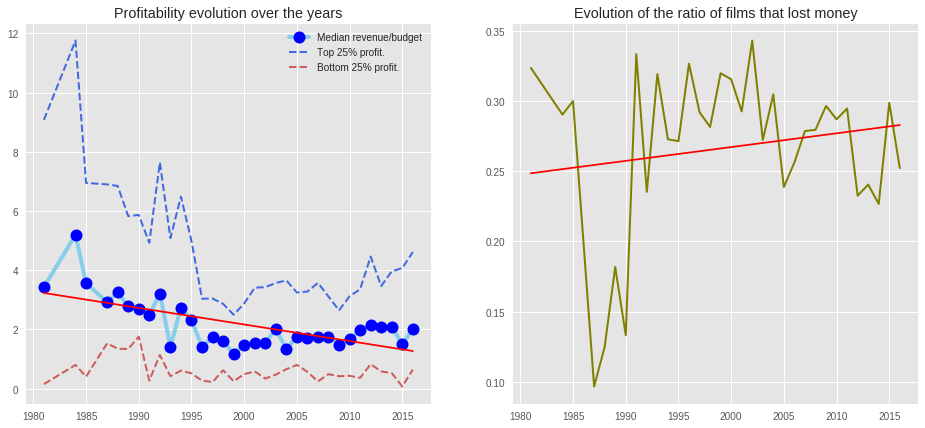

In [219]:
# We'll filter for those years with at least 30 films on the database

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

x=df_years.index[df_years.films>29]

axes[0].plot(x, 'revenue_ratio_median', data=df_years[df_years.films>29], marker='o'
             , markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label="Median revenue/budget")
axes[1].plot(x, 'flops_ratio', data=df_years[df_years.films>29], marker='', color='olive'
             , linewidth=2)
axes[0].plot(x, 'ratio_top25', data=df_years[df_years.films>29], marker='', color='royalblue'
             , linewidth=2, linestyle='dashed', label="Top 25% profit.")
axes[0].plot(x, 'ratio_bottom25', data=df_years[df_years.films>29], marker='', color='indianred'
             , linewidth=2, linestyle='dashed', label="Bottom 25% profit.")
axes[0].legend()
axes[0].set_title('Profitability evolution over the years')
axes[1].set_title('Evolution of the ratio of films that lost money')

fit = np.polyfit(x, df_years.flops_ratio[df_years.films>29], 1)
axes[1].plot(x, fit[0] * x + fit[1], color='red')

fit = np.polyfit(x, df_years.revenue_ratio_median[df_years.films>29], 1)
axes[0].plot(x, fit[0] * x + fit[1], color='red')


We can see that the profitability of films has not been getting better through the years. We could even argue that the trend has a downward slope, and that the ratio of films that don't even make it to breaking even is, if anything, increasing.

As it happened with the directors, the FB likes of the main cast doesn't improve the profitability of the film. If anything, it seems to be a negative correlation, probably because films with lower budgets and less known actors have a much greater potential for big profitability than big blockbusters.

#### We're going to review now what films in our database are the biggest flops. To do so, we will:

- Filter first by films with budget lower than revenue
- Filter by those films with a IMDB score under 5 and at least 100 votes
- Finnaly, sort those films by the amount of money they lost

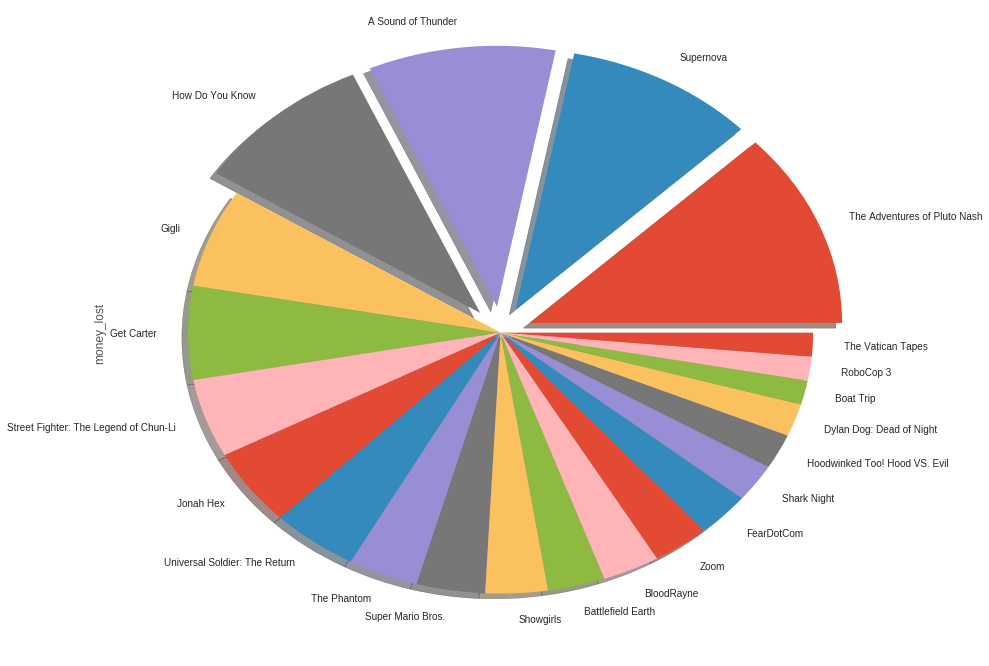

                                       money_lost  vote_average  \
original_title                                                    
The Adventures of Pluto Nash           92896027.0           4.4   
Supernova                              75171919.0           4.9   
A Sound of Thunder                     74010360.0           4.8   
How Do You Know                        71331093.0           4.9   
Gigli                                  46733791.0           3.5   
Get Carter                             44187007.0           4.8   
Street Fighter: The Legend of Chun-Li  37235799.0           3.9   
Jonah Hex                              36461000.0           4.4   
Universal Soldier: The Return          34332107.0           4.2   
The Phantom                            27699111.0           4.7   
Super Mario Bros.                      27084535.0           4.0   
Showgirls                              24649246.0           4.9   
Battlefield Earth                      22600000.0           3.

In [220]:
df_flops = data[data.revenue_budget_ratio<0.5][data.revenue_budget_ratio>0]
df_flops = df_flops[df_flops.vote_average<5][df_flops.vote_count>100]
df_flops['money_lost'] = (1-df_flops['revenue_budget_ratio'])*df_flops['budget']
df_flops.sort_values(by='money_lost',ascending=False,inplace = True)

#print(df_flops[['original_title','money_lost','vote_average']])

fig, ax = plt.subplots(figsize=(14,12));
plt.style.use('ggplot')
explode=[0.1,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
df_flops['money_lost'].plot(kind='pie',explode=explode, labels=df_flops.original_title, fontsize=10,shadow=True)
plt.show()

df_flops.set_index('original_title',inplace=True)

print(df_flops[['money_lost','vote_average','revenue_budget_ratio']])

### 5- What countries make the most profitable and valued films?

As a last question, to gather the different aspects of profitable movies, we can inspect the relationship of movie characteristics between different countries

In [221]:
df_countries = data.groupby('country').apply(lambda x: pd.Series\
                                             ({'Movie_likes_mean':x.movie_facebook_likes.mean(),
                                                'revenue_budget_ratio':x.revenue_budget_ratio.mean(),
                                                'budget_mean':x.budget.mean(),
                                                'revenue_mean':x.revenue.mean(),
                                                'runtime':x.runtime.mean(),
                                                'vote_average':x.vote_average.mean(),
                                                'films':x.country.count()}))

#### - Which are the countries with a higher revenue average?

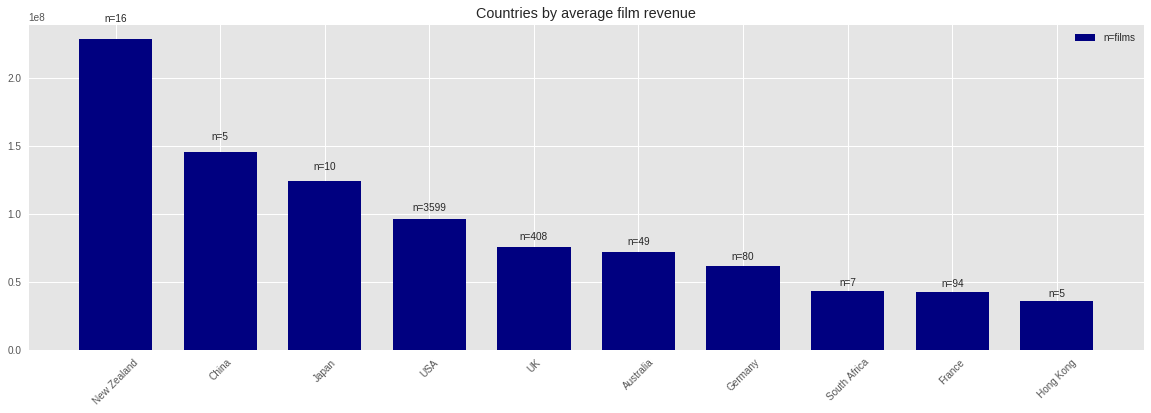

In [222]:
#We'll filter those countries with less than 3 films in the df

showbarplot(df_countries[df_countries.films>2],'revenue_mean',col2='films'\
            ,tit='Countries by average film revenue',nelements=10)

#### - Which country makes the most profitable movies?

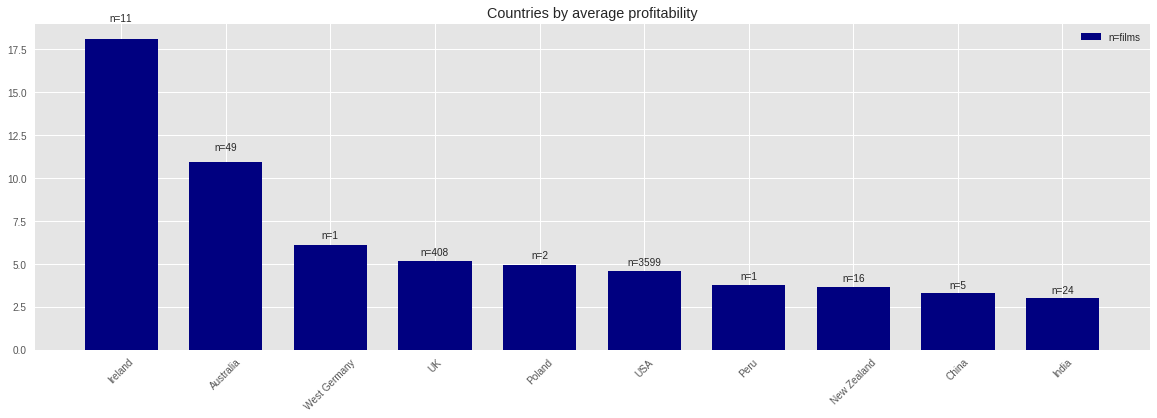

In [223]:
showbarplot(df_countries,'revenue_budget_ratio',col2='films',tit='Countries by average profitability',nelements=10)

It's important to note that these two previous lists are probably biased, as films from most countries don't enter IMDB unless they had enough budget or social impact, so the average revenue and revenue to budget ratios will be higher for films from those countries.

#### - Which country makes the most acclaimed films?

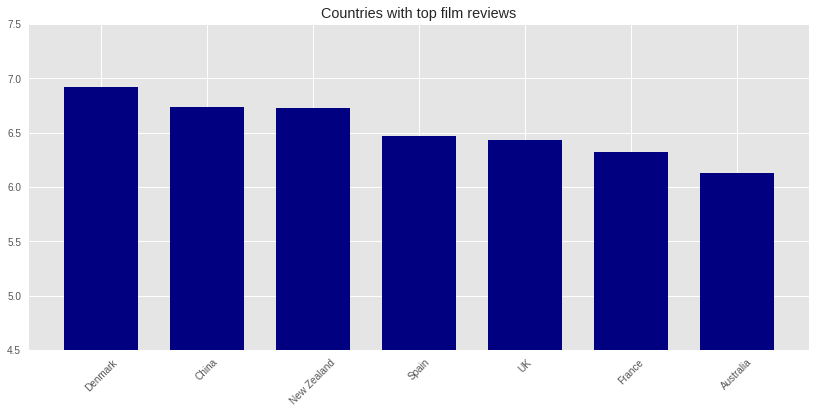


              vote_average  films   budget_mean  revenue_budget_ratio
country                                                             
Denmark          6.916667    6.0  1.236667e+07              1.655385
China            6.740000    5.0  4.650680e+07              3.280575
New Zealand      6.725000   16.0  6.615625e+07              3.657074
Spain            6.465000   20.0  1.504438e+07              2.452773
UK               6.431127  408.0  2.334388e+07              5.145738


In [224]:
#Filtering again by countries with more than 2 films

showbarplot(df_countries[df_countries.films>2],'vote_average',tit='Countries with top film reviews'
            ,nelements=7, ylim=[4.5,7.5])

print("\n",df_countries[['vote_average','films','budget_mean','revenue_budget_ratio']][df_countries.films>2]\
      .sort_values(by="vote_average",ascending=False).head())

#### - And which countries make the least acclaimed?

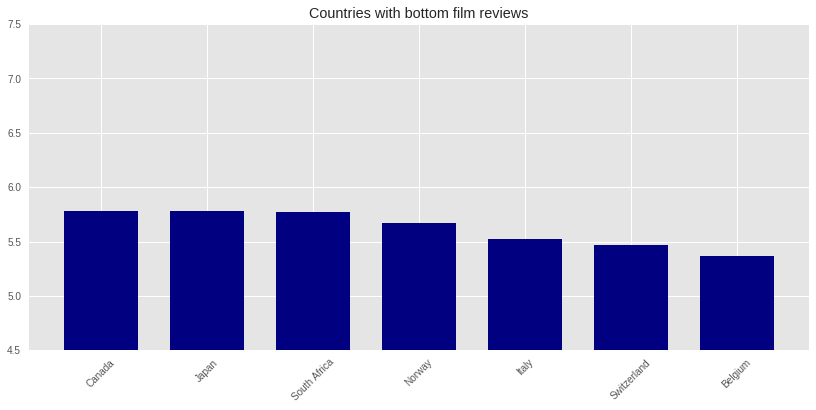


               vote_average  films   budget_mean  revenue_budget_ratio
country                                                              
South Africa      5.771429    7.0  1.571429e+07              2.213181
Norway            5.666667    3.0  1.833333e+06              0.909091
Italy             5.520000   10.0  1.500000e+07              0.335766
Switzerland       5.466667    3.0  1.016667e+07              0.000000
Belgium           5.366667    3.0  2.436667e+07              0.099969


In [225]:
#Whith the 3 films or more filter

showbarplot(df_countries[df_countries.films>2],'vote_average',tit='Countries with bottom film reviews'
            , ylim=[4.5,7.5], nelements=7,tail=True)

print("\n",df_countries[['vote_average','films','budget_mean','revenue_budget_ratio']][df_countries.films>2]\
      .sort_values(by="vote_average",ascending=False).tail())

#### - Which country makes the longest and shortest flims on average?

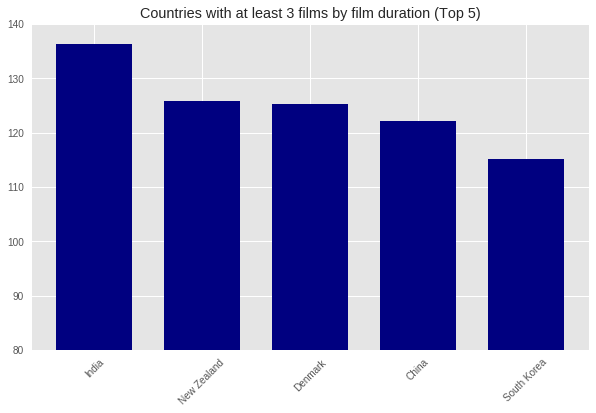

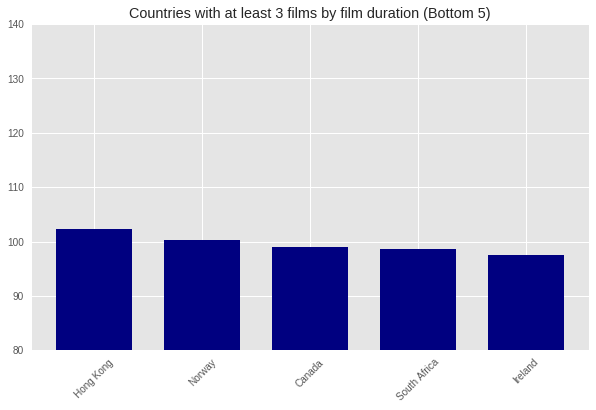

In [226]:
showbarplot(df_countries[df_countries.films>2],'runtime'
            ,tit='Countries with at least 3 films by film duration (Top 5)',nelements=5, ylim=[80,140])
showbarplot(df_countries[df_countries.films>2],'runtime'
            ,tit='Countries with at least 3 films by film duration (Bottom 5)',nelements=5,tail=True, ylim=[80,140])

It's courious to see how Ireland, with the highest revenue to budget ratio, makes the shortest films of all countries.